In [1]:
import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings("ignore", message="Parsing dates in .* when dayfirst=True was specified")
warnings.filterwarnings("ignore", category=FutureWarning)

from preprocessing import *
import tame
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
from config import CONFIG

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader, Subset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _cuda(obj):
    if isinstance(obj, torch.nn.Module):
        return obj.cuda()
    elif isinstance(obj, torch.Tensor):
        return obj.cuda()
    elif isinstance(obj, np.ndarray):
        return torch.from_numpy(obj).cuda()
    
def index_value(data):
    index = data // (CONFIG['split_num'] + 1)
    value = data % (CONFIG['split_num'] + 1)
    index = Variable(_cuda(index))
    value = Variable(_cuda(value))
    return [index, value]

In [2]:
dfs = get_dfs()
static_df= create_static_df(dfs)
biopsy_df = dfs['biopsy'].copy()
vital_df = create_vitals_df(dfs, static_df)
# count of nan values in vitals
print(vital_df.isna().sum())

med_df = create_medication_df(dfs, static_df)
lab_df = create_lab_values_df(dfs, static_df)
ts_data = create_ts_df(vital_df, lab_df, med_df, merge_lab=True, merge_med=True)
print(ts_data.columns)

full_dataset = NephroDataset(static_df, ts_data, biopsy_df, phase='test')
data_loader = DataLoader(full_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=4, collate_fn=collate_fn)

patient_id            0
transplant_id         0
rel_days              0
bp_sys            71896
bp_dia            71922
weight            70660
urine_volume     112786
heart_rate        82298
temperature      111655
diuresis_time    114678
dtype: int64
max rel_days 8034
max number of rows across all patients 1105
Index(['patient_id', 'transplant_id', 'rel_days', 'bp_sys', 'bp_dia', 'weight',
       'urine_volume', 'heart_rate', 'temperature', 'diuresis_time', 'albumin',
       'crphp', 'creatinine', 'leukocyte', 'proteinuria', 'L04AA06', 'L04AD01',
       'L04AD02'],
      dtype='object')


gender
m    61.813538
w    38.186462
Name: proportion, dtype: float64


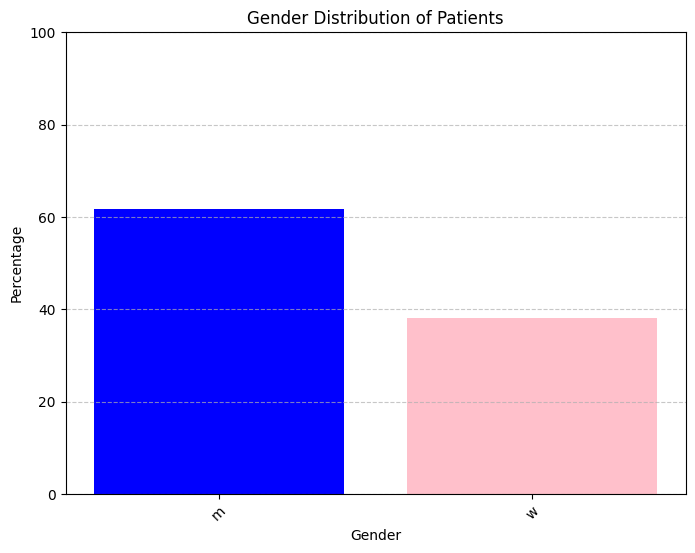

In [28]:
# calculate percentage of men and women
gender_counts = static_df['gender'].value_counts(normalize=True) * 100

print(gender_counts)
# plot gender distribution
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Gender Distribution of Patients')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


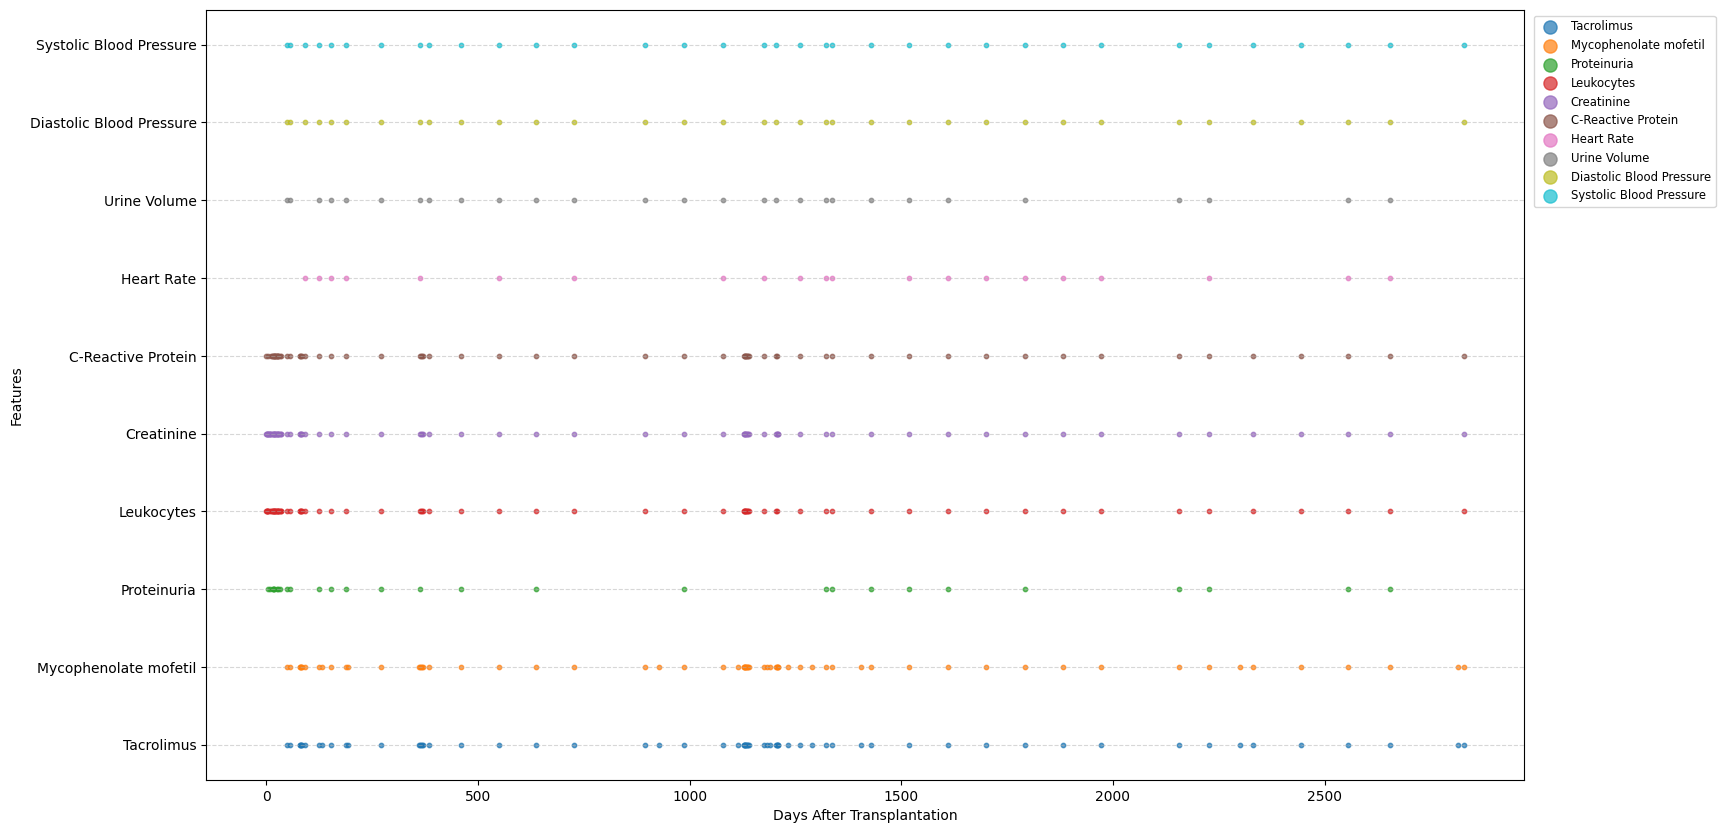

In [31]:
feature_map = {
    'L04AA06': 'Mycophenolate mofetil',
    'L04AD02': 'Tacrolimus',
    'L04AD01': 'Ciclosporin',
    'underlying_disease': 'Underlying Disease',
    'type_of_donation': 'Type of Donation', 
    'blood_group': 'Recipient Blood Group',
    'ebv_status': 'EBV Status', 
    'delayed_graft_function': 'Delayed Graft Function',  
    'donor_bloodgroup': 'Donor Blood Group',
    'gender': 'Recipient Gender', 
    'gender_donor': 'Donor Gender',
    'number_dialyses': 'Number of Dialyses', 
    'age': 'Recipient Age', 
    'height': 'Recipient Height', 
    'cold_ischemia_time': 'Cold Ischemia Time',
    'age_donor': 'Donor Age', 
    'days_in_hospital': 'Days in Hospital', 
    'number_transplantation': 'Number of Transplantations',
    'pirche_score': 'PIRCHE Score', 
    'risk_of_graft_failure': 'Risk of Graft Failure',
    'bp_sys': 'Systolic Blood Pressure', 
    'bp_dia': 'Diastolic Blood Pressure', 
    'weight': 'Weight', 
    'urine_volume': 'Urine Volume', 
    'heart_rate': 'Heart Rate', 
    'temperature': 'Temperature', 
    'diuresis_time': 'Diuresis Time', 
    'albumin': 'Albumin/Creatinine Ratio', 
    'crphp': 'C-Reactive Protein',
    'creatinine': 'Creatinine', 
    'leukocyte': 'Leukocytes', 
    'proteinuria': 'Proteinuria', 
}

ts_features = CONFIG['ts_feat'].copy()

#ts_features.remove('bp_dia')
ts_features.remove('albumin')
ts_features.remove('weight')
ts_features.remove('temperature')
ts_features.remove('diuresis_time')
ts_features.remove('L04AD01')

ts_features = ts_features[::-1]  

patient_id = '6290'#'33'
max_days = 3000

patient_ts_data = ts_data[ts_data['patient_id'] == patient_id]
data_availability = patient_ts_data[ts_features].notna()
data_availability['rel_days'] = patient_ts_data['rel_days']


# Limit data to max_days
data_availability = data_availability[data_availability['rel_days'] <= max_days]

# Plot data availability over time for all features
plt.figure(figsize=(17, 10))

# Plot time-series features availability
for idx, feature in enumerate(ts_features):
    feature_data = data_availability[['rel_days', feature]]
    available_days = feature_data[feature_data[feature]].rel_days
    plt.scatter(available_days, [idx] * len(available_days), label=feature_map.get(feature, feature), s=10, alpha=0.7)



# Customize plot
y_labels = [feature_map.get(feat, feat) for feat in ts_features]
plt.yticks(range(len(y_labels)), y_labels)
plt.xlabel('Days After Transplantation')
plt.ylabel('Features')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize='small', markerscale=3, bbox_to_anchor=(1.15, 1))
plt.show()


In [13]:
target_times = [0, 1,2,3,4,5,7,8,9,10,11,12,14,15,16,55,56,57,58,59,60,61,62,63,64,65,66,67,70,79,114,189,197,198,199,200,203,204,205,206,207,208,209,210,211,212,213,214,217,218,219,220,221,224,225,226,227,228,268,359,534,884,898,1065,1068,1071,1087,1477,1534,2159,2635,2688,3294,3973,4375,4383,4384,4386,4389,4390,4391,4406,4411,4412,4420,4435,4438,4657,5085,5481]

In [16]:
import numpy as np

def find_exact_or_near_times(dataset, target_times, top_k=5, cast_to_int=True):
    """
    dataset[i] -> dict with 'real_ts_data' (T, 1+F), col0 = time (days)
    target_times: list/array of desired times
    Returns:
      exact_hits: list of (idx, pid_or_None)
      near_misses: list of dicts {idx, pid, len, overlap, only_in_target, only_in_sample}
                   sorted by smallest symmetric difference then by largest overlap
    """
    tgt = np.asarray(target_times)
    if cast_to_int:
        tgt = tgt.astype(int)
    tgt_tuple = tuple(tgt.tolist())
    tgt_set = set(tgt.tolist())

    exact_hits = []
    near = []

    n = len(dataset)
    for i in range(n):
        sample = dataset[i]
        times = sample['real_ts_data'][:, 0].cpu().numpy()
        if cast_to_int:
            times = times.astype(int)

        pid = sample.get('patient_id', None) if isinstance(sample, dict) else None

        # exact: same length + identical sequence (order & values)
        if len(times) == len(tgt) and np.array_equal(times, tgt):
            exact_hits.append((i, pid))
            continue

        # prepare near-miss diagnostics
        s_set = set(times.tolist())
        only_in_target = sorted(list(tgt_set - s_set))
        only_in_sample = sorted(list(s_set - tgt_set))
        overlap = len(tgt_set & s_set)
        symdiff = len(only_in_target) + len(only_in_sample)

        near.append({
            "idx": i,
            "pid": pid,
            "len": len(times),
            "overlap": overlap,
            "symdiff": symdiff,
            "only_in_target": only_in_target[:10],   # truncate for readability
            "only_in_sample": only_in_sample[:10],   # truncate
            "min_sample": int(np.min(times)) if len(times) else None,
            "max_sample": int(np.max(times)) if len(times) else None,
        })

    # sort near-misses: smallest symmetric difference, then largest overlap, then closest length
    near.sort(key=lambda d: (d["symdiff"], -d["overlap"], abs(d["len"] - len(tgt))))

    return exact_hits, near[:top_k]

# ---------- usage ----------
target_times = [0, 1,2,3,4,5,7,8,9,10,11,12,14,15,16,55,56,57,58,59,60,61,62,63,64,65,66,67,70,79,114,189,197,198,199,200,203,204,205,206,207,208,209,210,211,212,213,214,217,218,219,220,221,224,225,226,227,228,268,359,534,884,898,1065,1068,1071,1087,1477,1534,2159,2635,2688,3294,3973,4375,4383,4384,4386,4389,4390,4391,4406,4411,4412,4420,4435,4438,4657,5085,5481]

exact, near = find_exact_or_near_times(full_dataset, target_times, top_k=5, cast_to_int=True)

if exact:
    for i, pid in exact:
        print(f"✅ Exact match — dataset index: {i}, patient_id: {pid}")
else:
    print("❌ No exact matches.")
    print("Top near-misses (why they failed):")
    for d in near:
        print(
            f"- idx={d['idx']}, pid={d['pid']}, len={d['len']}, "
            f"overlap={d['overlap']}, symdiff={d['symdiff']}, "
            f"min_sample={d['min_sample']}, max_sample={d['max_sample']}"
        )
        print(f"  only_in_target (first 10): {d['only_in_target']}")
        print(f"  only_in_sample (first 10): {d['only_in_sample']}")


❌ No exact matches.
Top near-misses (why they failed):
- idx=1567, pid=6256, len=91, overlap=90, symdiff=1, min_sample=0, max_sample=5481
  only_in_target (first 10): []
  only_in_sample (first 10): [4419]
- idx=1481, pid=5364, len=17, overlap=15, symdiff=77, min_sample=0, max_sample=16
  only_in_target (first 10): [55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
  only_in_sample (first 10): [6, 13]
- idx=3071, pid=35673, len=26, overlap=19, symdiff=78, min_sample=0, max_sample=794
  only_in_target (first 10): [12, 55, 56, 57, 58, 59, 61, 62, 63, 65]
  only_in_sample (first 10): [6, 13, 409, 486, 612, 703, 794]
- idx=2158, pid=8294, len=18, overlap=15, symdiff=78, min_sample=0, max_sample=18
  only_in_target (first 10): [55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
  only_in_sample (first 10): [6, 13, 18]
- idx=761, pid=2768, len=16, overlap=14, symdiff=78, min_sample=0, max_sample=16
  only_in_target (first 10): [14, 55, 56, 57, 58, 59, 60, 61, 62, 63]
  only_in_sample (first 10): [6, 13]


In [19]:
import torch
import numpy as np

target_pid = "6256"

with torch.no_grad():
    for batch in data_loader:
        pids = batch["patient_id"]
        if target_pid in pids:
            i = pids.index(target_pid)

            seq_len = int(batch["seq_len"][i].item())
            real_ts = batch["real_ts_data"][i, :seq_len, :]   # (T, 1+F)
            times = real_ts[:, 0].cpu().numpy()
            vals = real_ts[:, 1:].cpu().numpy()               # drop time column

            F = vals.shape[1]
            for t in range(seq_len):
                missing_feats = np.where(np.isnan(vals[t]))[0]  # indices of NaN features
                if len(missing_feats) > 0:
                    print(f"Patient {target_pid}, time={times[t]} → missing features: {missing_feats.tolist()}")
                else:
                    print(f"Patient {target_pid}, time={times[t]} → no missing features")

            break


Patient 6256, time=0.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13]
Patient 6256, time=1.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14]
Patient 6256, time=2.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 12, 13]
Patient 6256, time=3.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13]
Patient 6256, time=4.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13]
Patient 6256, time=5.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]
Patient 6256, time=7.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13]
Patient 6256, time=8.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]
Patient 6256, time=9.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 12, 13]
Patient 6256, time=10.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13]
Patient 6256, time=11.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13]
Patient 6256, time=12.0 → missing features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Patient 6256, time=1

Total number of patients: 3132
Patients with graft loss: 550
Minimum days to graft loss: 0.0
Minum days to graft loss (excluding 0): 1.0


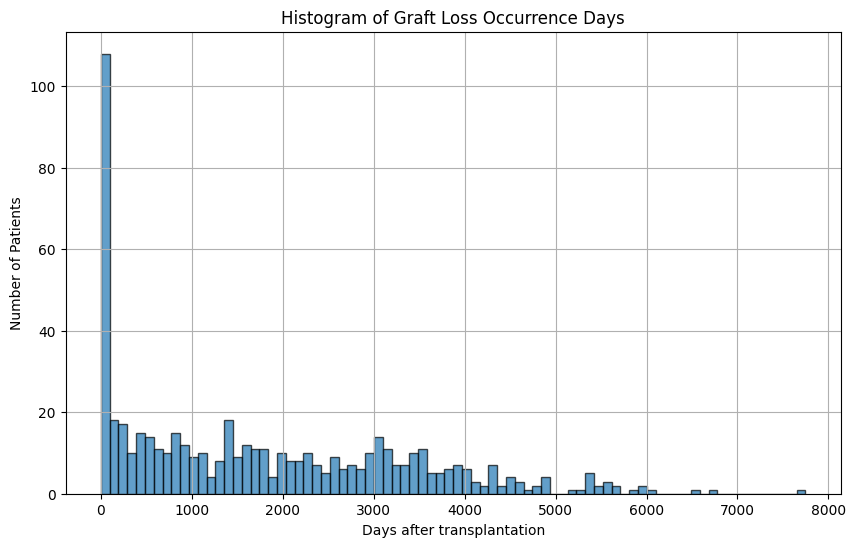

In [13]:
total_patients = len(static_df)

# Patients with graft loss
graft_loss_patients = static_df['loss_rel_days'].notna().sum()

# Print summary
print(f"Total number of patients: {total_patients}")
print(f"Patients with graft loss: {graft_loss_patients}")
print(f"Minimum days to graft loss: {static_df['loss_rel_days'].min()}")
print(f"Minum days to graft loss (excluding 0): {static_df['loss_rel_days'][static_df['loss_rel_days'] > 0].min()}")

# Plot histogram of graft loss occurrence days
graft_loss_days = static_df['loss_rel_days'].dropna()

plt.figure(figsize=(10, 6))
plt.hist(graft_loss_days, bins=80, edgecolor='black', alpha=0.7)
plt.title('Histogram of Graft Loss Occurrence Days')
plt.xlabel('Days after transplantation')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()

Total number of patients: 3132
Patients who died: 982


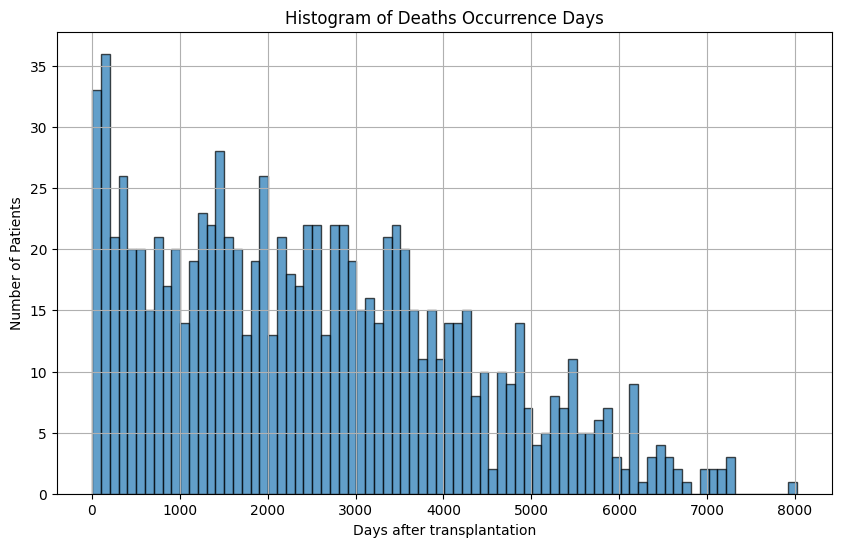

In [ ]:
total_patients = len(static_df)

dead_patients = static_df['death_rel_days'].notna().sum()

print(f"Total number of patients: {total_patients}")
print(f"Patients who died: {dead_patients}")

# Plot histogram of graft loss occurrence days
death_rel_days = static_df['death_rel_days'].dropna()

plt.figure(figsize=(10, 6))
plt.hist(death_rel_days, bins=80, edgecolor='black', alpha=0.7)
plt.title('Histogram of Deaths Occurrence Days')
plt.xlabel('Days after transplantation')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()

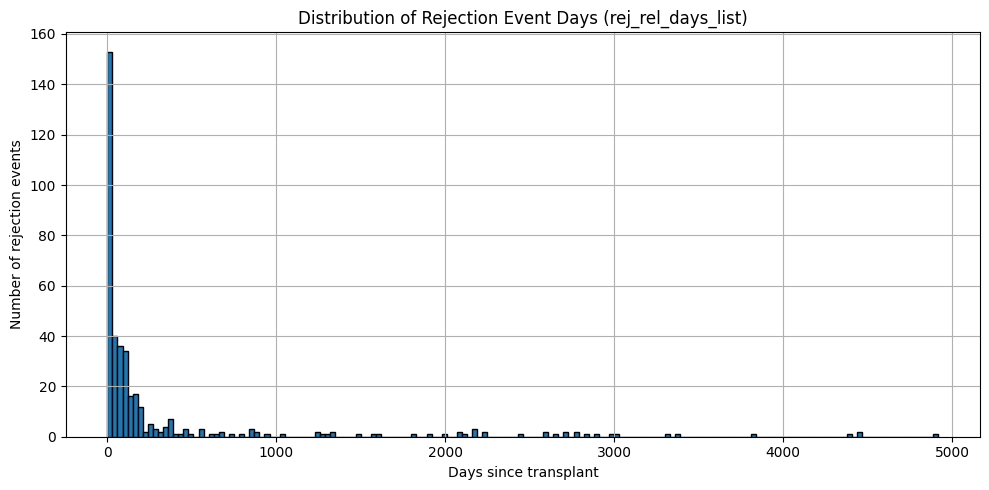

In [ ]:
all_rej_days = []

for batch in data_loader:
    batch_rej_lists = batch['rej_rel_days_list']

    for rej_list in batch_rej_lists:
        if rej_list is None:
            continue  # skip None entries

        if isinstance(rej_list, torch.Tensor):
            rej_list = rej_list.cpu().numpy()

        try:
            # Flatten in case it's wrapped in another container
            for day in rej_list:
                if day is not None:
                    day_float = float(day)
                    if not np.isnan(day_float):
                        all_rej_days.append(int(day_float))
        except TypeError:
            # If rej_list is a single float or something non-iterable
            try:
                day_float = float(rej_list)
                if not np.isnan(day_float):
                    all_rej_days.append(int(day_float))
            except:
                continue

plt.figure(figsize=(10, 5))
plt.hist(all_rej_days, bins=range(0, max(all_rej_days)+30, 30), edgecolor='black')
plt.xlabel('Days since transplant')
plt.ylabel('Number of rejection events')
plt.title('Distribution of Rejection Event Days')
plt.grid(True)
plt.tight_layout()
plt.show()

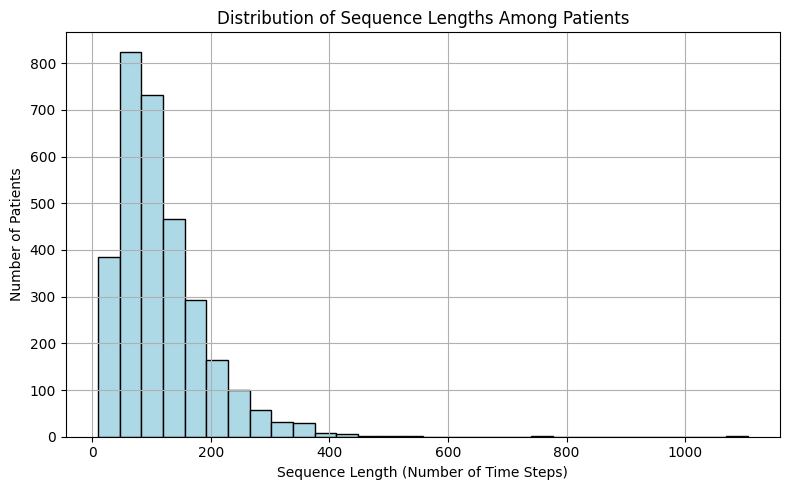

Min: 10 | Max: 1105 | Mean: 115.38 | Median: 99.0 | Std: 74.12


In [ ]:
# max sequence length == 473
import matplotlib.pyplot as plt
import numpy as np

# Collect sequence lengths
seq_lens = []
for i in range(len(full_dataset)):
    seq_lens.append(full_dataset[i]['seq_len'])

# Convert to NumPy array for stats
seq_lens = np.array(seq_lens)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(seq_lens, bins=30, color='lightblue', edgecolor='black')
plt.xlabel('Sequence Length (Number of Time Steps)')
plt.ylabel('Number of Patients')
plt.title('Distribution of Sequence Lengths Among Patients')
plt.grid(True)
plt.tight_layout()
plt.show()

# statistics
print(f"Min: {seq_lens.min()} | Max: {seq_lens.max()} | Mean: {seq_lens.mean():.2f} | Median: {np.median(seq_lens)} | Std: {seq_lens.std():.2f}")


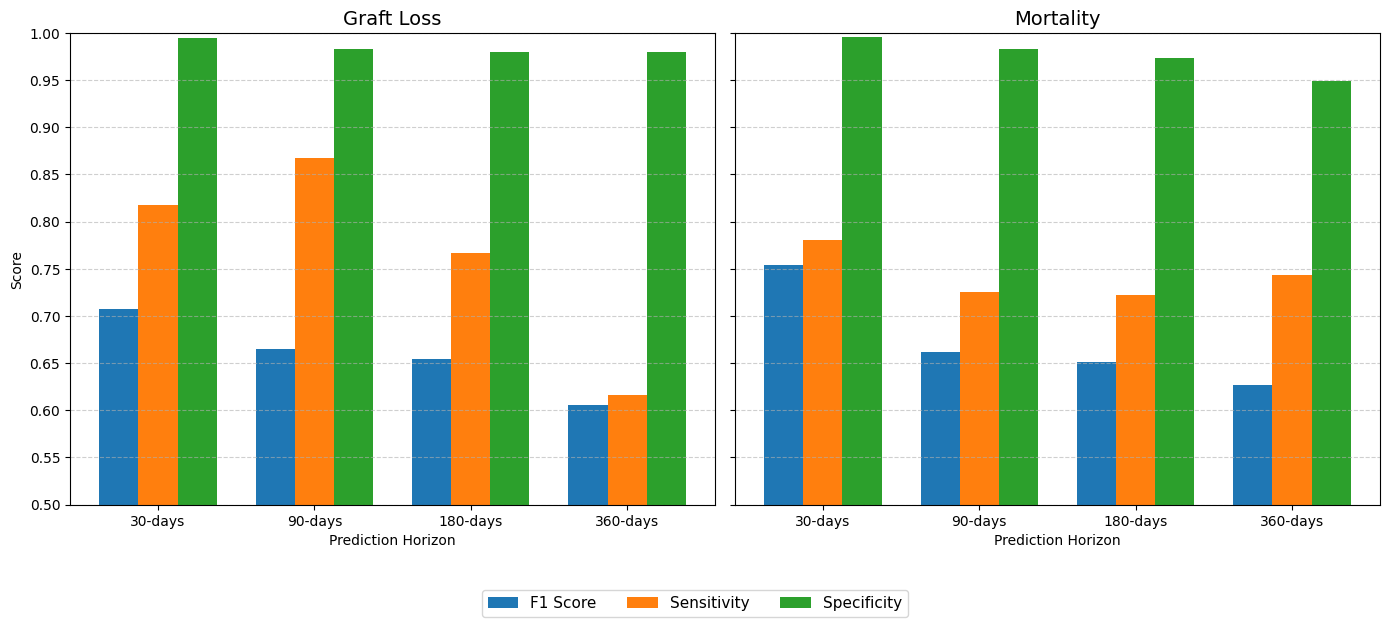

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy values: metrics for each horizon (rows) per task
# Format: [30-day, 90-day, 180-day, 360-day]
graft_loss_metrics = {
    'F1 Score':      [0.7073, 0.6648, 0.6540, 0.6051],
    'Sensitivity':   [0.8178, 0.8671, 0.7671, 0.6160],
    'Specificity':   [0.9947, 0.9831, 0.9795, 0.9794]
}

mortality_metrics = {
    'F1 Score':      [0.7536, 0.6619, 0.6513, 0.6270],
    'Sensitivity':   [0.7806, 0.7258, 0.7227, 0.7438],
    'Specificity':   [0.9953, 0.9829, 0.9732, 0.9489]
}

horizons = ['30-days', '90-days', '180-days', '360-days']
metric_names = ['F1 Score', 'Sensitivity', 'Specificity']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bar_width = 0.25
x = np.arange(len(horizons))  # positions for groups

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot function
def plot_grouped_bars(ax, data, title):
    for i, metric in enumerate(metric_names):
        values = data[metric]
        ax.bar(x + i * bar_width, values, width=bar_width,
               label=metric, color=colors[i])

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(horizons)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Prediction Horizon")
    ax.set_yticks(np.arange(0.5, 1.01, 0.05))  # for ticks every 0.05
    ax.set_ylim(0.5, 1.0)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Plot each subplot
plot_grouped_bars(axes[0], graft_loss_metrics, "Graft Loss")
plot_grouped_bars(axes[1], mortality_metrics, "Mortality")

axes[0].set_ylabel("Score")

fig.legend(metric_names, loc='lower center', ncol=3, fontsize=11, bbox_to_anchor=(0.5, -0.05))

# Layout adjustments
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('graft_loss_mortality_metrics.png', dpi=300)
plt.show()
